## الانحدار الخطي والانحدار متعدد الحدود لتسعير القرع - الدرس الثالث

قم بتحميل المكتبات والبيانات المطلوبة. قم بتحويل البيانات إلى إطار بيانات يحتوي على جزء من البيانات:

- احصل فقط على القرع الذي تم تسعيره بوحدة البوشل
- قم بتحويل التاريخ إلى شهر
- احسب السعر ليكون متوسط الأسعار المرتفعة والمنخفضة
- قم بتحويل السعر ليعكس التسعير بوحدة كمية البوشل


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../../data/US-pumpkins.csv')
pumpkins.head()

City Name Type       Package      Variety Sub Variety  Grade     Date  \
0  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN  4/29/17   
1  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN   5/6/17   
2  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
3  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
4  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  11/5/16   

   Low Price  High Price  Mostly Low  ...  Unit of Sale Quality Condition  \
0      270.0       280.0       270.0  ...           NaN     NaN       NaN   
1      270.0       280.0       270.0  ...           NaN     NaN       NaN   
2      160.0       160.0       160.0  ...           NaN     NaN       NaN   
3      160.0       160.0       160.0  ...           NaN     NaN       NaN   
4       90.0       100.0        90.0  ...           NaN     NaN       NaN   

  Appearance Storage  Crop Repack  Trans Mode  Unnamed: 24  Unnamed: 25  
0        NaN     NaN   NaN      E         NaN          NaN          NaN  
1        NaN     NaN   NaN      E         NaN          NaN          NaN  
2        NaN     NaN   NaN      N         NaN          NaN          NaN  
3        NaN     NaN   NaN      N         NaN          NaN          NaN  
4        NaN     NaN   NaN      N         NaN          NaN          NaN  

[5 rows x 26 columns]

In [168]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Month  DayOfYear   Variety       City               Package  Low Price  \
70      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   
71      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
72     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
73     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       17.0   
74     10        281  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   

    High Price      Price  
70        15.0  13.636364  
71        18.0  16.363636  
72        18.0  16.363636  
73        17.0  15.454545  
74        15.0  13.636364

تذكرنا مخططات الانتشار بأن لدينا بيانات الأشهر فقط من أغسطس حتى ديسمبر. من المحتمل أننا بحاجة إلى المزيد من البيانات لنتمكن من استخلاص استنتاجات بطريقة خطية.


<AxesSubplot:xlabel='Month', ylabel='Price'>

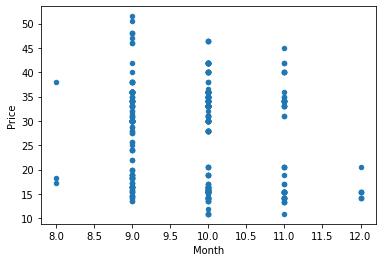

In [169]:
new_pumpkins.plot.scatter('Month','Price')

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

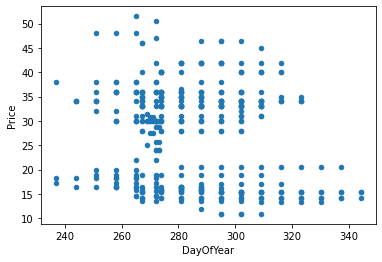

In [170]:
new_pumpkins.plot.scatter('DayOfYear','Price')

لنرَ إذا كان هناك ارتباط:


In [171]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


يبدو أن الارتباط صغير جدًا، ولكن هناك علاقة أخرى أكثر أهمية - لأن نقاط الأسعار في الرسم البياني أعلاه تبدو وكأنها تحتوي على عدة مجموعات مميزة. لنقم بإنشاء رسم بياني يُظهر أنواع القرع المختلفة:


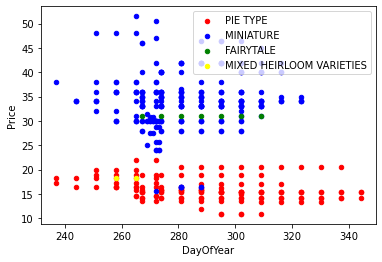

In [172]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='Variety'>

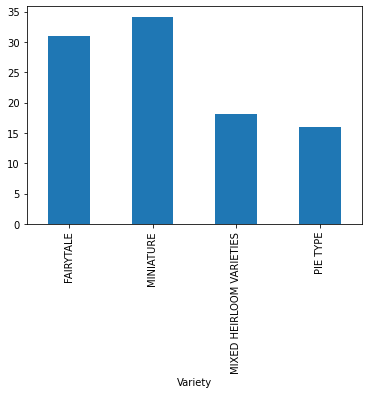

In [173]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

-0.2669192282197318


<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

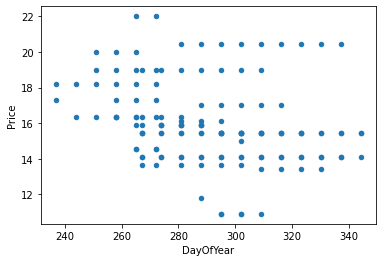

In [174]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
pie_pumpkins.plot.scatter('DayOfYear','Price')

### الانحدار الخطي

سنستخدم مكتبة Scikit Learn لتدريب نموذج الانحدار الخطي:


In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [176]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')


Mean error: 2.77 (17.2%)


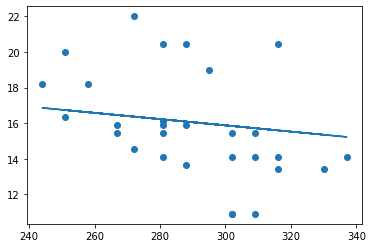

In [177]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

يمكن تحديد ميل الخط من معاملات الانحدار الخطي:


In [178]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

يمكننا استخدام النموذج المدرب لتوقع السعر:


In [179]:
# Pumpkin price on programmer's day

lin_reg.predict([[256]])

array([16.64893156])

### الانحدار متعدد الحدود

في بعض الأحيان تكون العلاقة بين الميزات والنتائج غير خطية بطبيعتها. على سبيل المثال، قد تكون أسعار القرع مرتفعة في الشتاء (الشهور=1،2)، ثم تنخفض خلال الصيف (الشهور=5-7)، ثم ترتفع مرة أخرى. الانحدار الخطي غير قادر على تحديد هذه العلاقة بدقة.

في هذه الحالة، يمكننا التفكير في إضافة ميزات إضافية. الطريقة البسيطة هي استخدام الحدوديات من الميزات المدخلة، مما يؤدي إلى **الانحدار متعدد الحدود**. في مكتبة Scikit Learn، يمكننا حساب الميزات متعددة الحدود تلقائيًا باستخدام الأنابيب:


Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280217


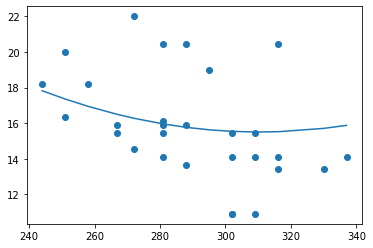

In [180]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

### أنواع الترميز

في العالم المثالي، نريد أن نتمكن من التنبؤ بأسعار أنواع مختلفة من القرع باستخدام نفس النموذج. لأخذ النوع في الاعتبار، نحتاج أولاً إلى تحويله إلى شكل رقمي، أو **ترميزه**. هناك عدة طرق يمكننا القيام بذلك:

* ترميز رقمي بسيط يقوم بإنشاء جدول لأنواع مختلفة، ثم يستبدل اسم النوع بمؤشر في ذلك الجدول. هذه ليست أفضل فكرة بالنسبة للانحدار الخطي، لأن الانحدار الخطي يأخذ القيمة الرقمية للمؤشر في الاعتبار، والقيمة الرقمية من المحتمل ألا تكون مرتبطة عدديًا بالسعر.
* الترميز الأحادي (One-hot encoding)، الذي سيستبدل عمود `Variety` بأربعة أعمدة مختلفة، واحد لكل نوع، يحتوي على 1 إذا كانت الصفوف المقابلة من النوع المعطى، و0 خلاف ذلك.

الكود أدناه يوضح كيف يمكننا ترميز النوع باستخدام الترميز الأحادي:


In [181]:
pd.get_dummies(new_pumpkins['Variety'])

FAIRYTALE  MINIATURE  MIXED HEIRLOOM VARIETIES  PIE TYPE
70            0          0                         0         1
71            0          0                         0         1
72            0          0                         0         1
73            0          0                         0         1
74            0          0                         0         1
...         ...        ...                       ...       ...
1738          0          1                         0         0
1739          0          1                         0         0
1740          0          1                         0         0
1741          0          1                         0         0
1742          0          1                         0         0

[415 rows x 4 columns]

### الانحدار الخطي على التنوع

سنستخدم الآن نفس الكود المذكور أعلاه، ولكن بدلاً من `DayOfYear` سنستخدم التنوع المشفر بطريقة الـ one-hot كمدخل:


In [182]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [183]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 5.24 (19.7%)
Model determination:  0.774085281105197


يمكننا أيضًا تجربة استخدام ميزات أخرى بنفس الطريقة، ودمجها مع الميزات العددية، مثل `Month` أو `DayOfYear`:


In [184]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

run_linear_regression(X,y)

Mean error: 2.84 (10.5%)
Model determination:  0.9401096672643048


### الانحدار متعدد الحدود

يمكن استخدام الانحدار متعدد الحدود أيضًا مع الميزات الفئوية التي تم ترميزها بطريقة التشفير الواحد-الساخن. سيكون الكود المستخدم لتدريب الانحدار متعدد الحدود مشابهًا بشكل أساسي لما رأيناه أعلاه.


In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.25%)
Model determination:  0.9652870784724543



---

**إخلاء المسؤولية**:  
تم ترجمة هذا المستند باستخدام خدمة الترجمة بالذكاء الاصطناعي [Co-op Translator](https://github.com/Azure/co-op-translator). بينما نسعى لتحقيق الدقة، يرجى العلم أن الترجمات الآلية قد تحتوي على أخطاء أو معلومات غير دقيقة. يجب اعتبار المستند الأصلي بلغته الأصلية هو المصدر الموثوق. للحصول على معلومات حساسة أو هامة، يُوصى بالاستعانة بترجمة بشرية احترافية. نحن غير مسؤولين عن أي سوء فهم أو تفسيرات خاطئة ناتجة عن استخدام هذه الترجمة.
